# RandomForest vs KNN on MNIST
### Linsheng Liu
### Mistakes are corrected and more tests are made thanks to the following work: 
#### https://www.kaggle.com/sflender/comparing-random-forest-pca-and-knn

In [1]:
# load the modules

import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# We use this function in order to evaulate a classifier. It trains on a fraction of the data corresponding to 
# aplit_ratio, and evaulates on the rest of the data

def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)

In [3]:
import os
cwd = os.getcwd()

In [4]:
# read in the data
# For Linux/Mac, replace \\ into /
train = pd.read_csv(cwd+'\\inputs\\train.csv')
test  = pd.read_csv(cwd+'\\inputs\\test.csv')
target = train["label"]
train = train.drop("label",1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


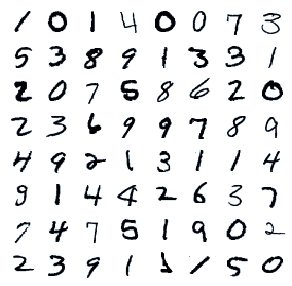

In [5]:
# plot some of the numbers

figure(figsize(5,5))
for digit_num in range(0,64):
    subplot(8,8,digit_num+1)
    grid_data = train.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    xticks([])
    yticks([])

In [13]:
# check performance of random forest classifier, as function of number of estimators 
# here we only take 2000 data points to train

n_estimators_array = np.array([1,5,10,50,100,200,500])
n_samples = 10
n_grid = len(n_estimators_array)
score_array_mu =np.zeros(n_grid)
score_array_sigma = np.zeros(n_grid)
j=0
for n_estimators in n_estimators_array:
    score_array=np.zeros(n_samples)
    for i in range(0,n_samples):
        clf = RandomForestClassifier(n_estimators = n_estimators, n_jobs=1, criterion="gini")
        score_array[i] = evaluate_classifier(clf, train.iloc[0:2000], target.iloc[0:2000], 0.8)
    score_array_mu[j], score_array_sigma[j] = mean(score_array), std(score_array)
    j=j+1

In [20]:
from datetime import datetime
start=datetime.now()

clf = RandomForestClassifier(n_estimators = 100, n_jobs=1, criterion="gini")
score = evaluate_classifier(clf, train.iloc[0:2000], target.iloc[0:2000], 0.8)

print("The runtime of random forest is")
print(datetime.now()-start)
print("Accuracy is")
print(score)

The runtime of random forest is
0:00:00.474770
Accuracy is
0.91


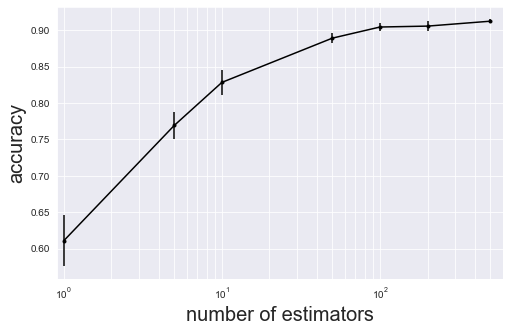

In [14]:
# it looks like the performace saturates around 50-100 estimators

figure(figsize(8,5))
errorbar(n_estimators_array, score_array_mu, yerr=score_array_sigma, fmt='k.-')
xscale("log")
xlabel("number of estimators",size = 20)
ylabel("accuracy",size = 20)
xlim(0.9,600)
grid(which="both")

Are there any feature that are particularly important? We can check this using clf.feature_importances:
My answer is that, this is not useful for 784 pixels.

Feature ranking:
1. feature 378 (0.009662)
2. feature 409 (0.008761)
3. feature 433 (0.007280)
4. feature 406 (0.007171)
5. feature 155 (0.006951)
6. feature 461 (0.006842)
7. feature 405 (0.006724)
8. feature 350 (0.006527)
9. feature 437 (0.006369)
10. feature 597 (0.006240)


Text(0, 0.5, 'importance')

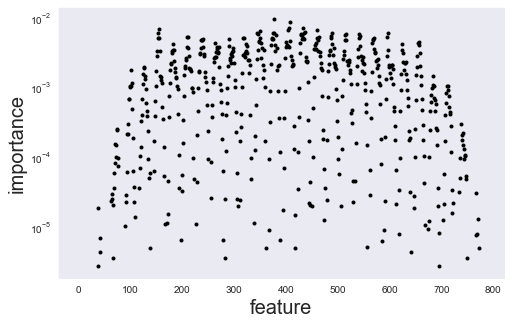

In [11]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(0,10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances

figure(figsize(8,5))
plot(indices[:],importances[indices[:]],'k.')
yscale("log")
xlabel("feature",size=20)
ylabel("importance",size=20)

It looks like there are no significantly important features (i.e., pixels) in the original data. Next, let us try to decompose the data using a principal component analysis (PCA):

Text(0, 0.5, 'PC2')

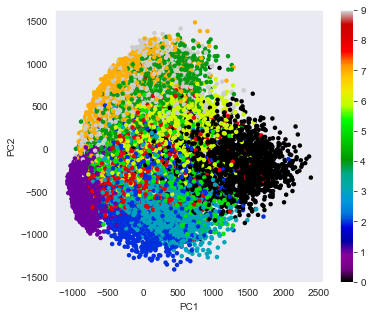

In [21]:
pca = PCA(n_components=2)
pca.fit(train)
transform = pca.transform(train)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = target, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
clim(0,9)

xlabel("PC1")
ylabel("PC2")

It is interesting to see how well PCA separates the feature space into visible clusters already for 2 components. Next, let's look at what happens if we increase the number of components in PCA. In particular, we would like to know how many components are needed to capture most of the variance in the data. For this we will use the pca.explained_variance_ratio function.

In [22]:
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    vr[i] = sum(pca.explained_variance_ratio_)
    i=i+1    

Text(0, 0.5, 'variance ratio')

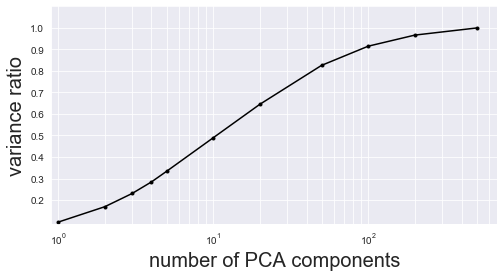

In [23]:
figure(figsize(8,4))
plot(n_components_array,vr,'k.-')
xscale("log")
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which="both")
xlabel("number of PCA components",size=20)
ylabel("variance ratio",size=20)

We see that ~100 PCA components are needed to capture ~90% of the variance in the data. This seems a lot of components. Maybe the more important question is: How good is our prediction as a function of number of components? Let's look at this next. We will train a kNN classifier on the PCA output.

In [26]:
clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    transform = pca.transform(train.iloc[0:2000])
    score_array[i] = evaluate_classifier(clf, transform, target.iloc[0:2000], 0.8)
    i=i+1

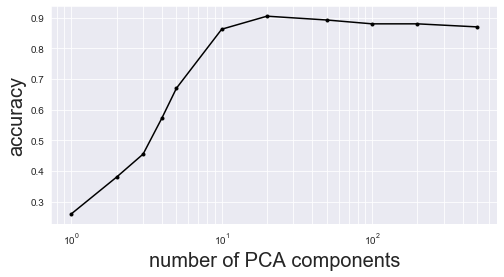

In [27]:
figure(figsize(8,4))
plot(n_components_array,score_array,'k.-')
xscale('log')
xlabel("number of PCA components", size=20)
ylabel("accuracy", size=20)
grid(which="both")

In [36]:
from datetime import datetime
clf = KNeighborsClassifier()
n_components = 20
score = 0

start=datetime.now()

pca = PCA(n_components = n_components)
pca.fit(train)
transform = pca.transform(train.iloc[0:2000])
score = evaluate_classifier(clf, transform, target.iloc[0:2000], 0.8)

print("The runtime of KNN after PCA is")
print(datetime.now()-start)
print("Accuracy is")
print(score)

The runtime of KNN after PCA is
0:00:00.959458
Accuracy is
0.905


Directly Apply KNN on the 2000 data. 

In [40]:
from datetime import datetime
clf = KNeighborsClassifier()
score = 0

start=datetime.now()



score = evaluate_classifier(clf, train.iloc[0:2000], target.iloc[0:2000], 0.8)

print("The runtime of KNN is")
print(datetime.now()-start)
print("Accuracy is")
print(score)

The runtime of KNN is
0:00:00.624429
Accuracy is
0.87


The accuracy seems to saturate at \~90% (roughly matching the performance of the random forest classifier) for >~20 PCA components. In fact, the accuracy even seems to drop for much larger numbers, even though a larger number of PCA components captures more of the variance in the data, as seen in the plot above. The drop in accuracy is probably due to overfitting.

Finally, we will train on the whole training set and prepare a submit file for the Kaggle competition.

## Random Forest On Whole Dataset

In [35]:
from datetime import datetime
start=datetime.now()

clf = RandomForestClassifier(n_estimators = 100, n_jobs=1, criterion="gini")
score = evaluate_classifier(clf, train.iloc[:], target.iloc[:], 0.8)

print("The runtime of random forest is")
print(datetime.now()-start)
print("Accuracy is")
print(score)

The runtime of random forest is
0:00:16.318564
Accuracy is
0.9648809523809524


## KNN On Whole Dataset

In [41]:
from datetime import datetime
clf = KNeighborsClassifier()
score = 0

start=datetime.now()



score = evaluate_classifier(clf, train.iloc[:], target.iloc[:], 0.8)

print("The runtime of KNN is")
print(datetime.now()-start)
print("Accuracy is")
print(score)

The runtime of KNN is
0:05:04.203420
Accuracy is
0.9680952380952381


## PCA then KNN On Whole Dataset

In [42]:
from datetime import datetime
clf = KNeighborsClassifier()
n_components = 20
score = 0

start=datetime.now()

pca = PCA(n_components = n_components)
pca.fit(train)
transform = pca.transform(train.iloc[:])
score = evaluate_classifier(clf, transform, target.iloc[:], 0.8)

print("The runtime of KNN after PCA is")
print(datetime.now()-start)
print("Accuracy is")
print(score)

The runtime of KNN after PCA is
0:00:04.474487
Accuracy is
0.9652380952380952
